In [1]:
!ls ./sample_data

anscombe.json		      mnist_test.csv
california_housing_test.csv   mnist_train_small.csv
california_housing_train.csv  README.md


In [2]:
# !pip3 install utils

In [3]:
import os
import torch
from torchvision import transforms
from PIL import Image
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np


from torch.optim import Adam, LBFGS
from torch.autograd import Variable


In [4]:

def prepare_img(img_path, target_shape, device):
    img = load_image(img_path, target_shape=target_shape)

    # normalize using ImageNet's mean
    # [0, 255] range worked much better for me than [0, 1] range (even though PyTorch models were trained on latter)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255)),
        transforms.Normalize(mean=IMAGENET_MEAN_255, std=IMAGENET_STD_NEUTRAL)
    ])

    img = transform(img).to(device).unsqueeze(0)

    return img

In [5]:
config = {}

config["content_img_path"] = "./green_bridge.jpg"
config["style_img_path"] = "./vg_la_cafe.jpg"
config["output_img_dir"] = "./"

In [6]:
content_img = cv.imread(config["content_img_path"])[:, :, ::-1]
style_img = cv.imread(config["style_img_path"])[:, :, ::-1]

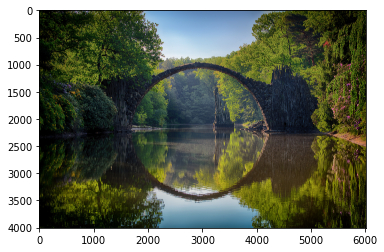

In [7]:
plt.imshow(content_img)

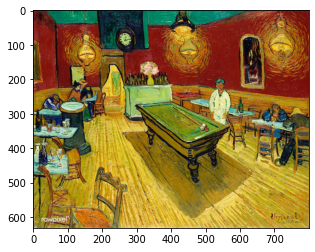

In [8]:
plt.imshow(style_img)

In [9]:
content_img.shape, style_img.shape

((4005, 6010, 3), (631, 800, 3))

In [10]:
new_height = 800
# new_width = 485
current_height, current_width = content_img.shape[0], content_img.shape[1]

In [11]:
new_content_shape = (int(new_height * (current_width/current_height)), new_height)


In [12]:
new_content_shape[0]/new_content_shape[1], content_img.shape[0]/content_img.shape[1]

(1.5, 0.6663893510815307)

In [13]:
(5184*485)/3456, new_content_shape

(727.5, (1200, 800))

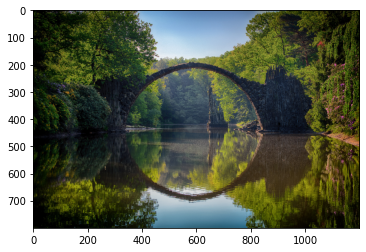

In [14]:
resized_content = cv.resize(content_img, new_content_shape)
plt.imshow(resized_content)

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [16]:
# resized_content.shape



In [17]:
IMAGENET_MEAN_255 = [123.675, 116.28, 103.53]
IMAGENET_STD_NEUTRAL = [1, 1, 1]
def prepare_img(img):

    # normalize using ImageNet's mean
    # [0, 255] range worked much better for me than [0, 1] range (even though PyTorch models were trained on latter)
    # print(img.shape)
    # img = torch.from_numpy(img)

    transform = transforms.Compose([
        transforms.ToTensor(),
        # transforms.Lambda(lambda x: x.mul(255)),
        transforms.Normalize(mean=IMAGENET_MEAN_255, std=IMAGENET_STD_NEUTRAL)
    ])

    
    # print(img.shape)
    img = transform(img).to(device).unsqueeze(0)
    # img = torch.unsqueeze(img.permute((1, 2, 0)).contiguous(),0)
    # print(img.shape)

    return img

In [18]:
style_img = style_img.astype(np.float32)
content_img = resized_content.astype(np.float32)
# content_img /= 255.0
# style_img /= 255.0

content_img.shape, style_img.shape

((800, 1200, 3), (631, 800, 3))

In [19]:
style_img = prepare_img(style_img)
content_img = prepare_img(content_img)


In [20]:
content_img.shape

torch.Size([1, 3, 800, 1200])

In [21]:


gaussian_noise_img = np.random.normal(loc=0, scale=90., size=content_img.shape).astype(np.float32)
init_img = torch.from_numpy(gaussian_noise_img).float().to(device)

# plt.imshow(init_img.squeeze(0))


optimizing_img = Variable(init_img, requires_grad=True)
# optimizing_img = optimizing_img.unsqueeze(0)

In [22]:
# models.vgg16(pretrained=True)

In [23]:
from torchvision import models
import copy
from collections import namedtuple

class Vgg16(torch.nn.Module):
    """Only those layers are exposed which have already proven to work nicely."""
    def __init__(self, requires_grad=False, show_progress=False):
        super().__init__()
        vgg_pretrained_features = models.vgg16(pretrained=True, progress=show_progress).features
        # print(vgg_pretrained_features)
        self.layer_names = ['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', "relu5_3"]
        self.content_feature_maps_index = 1  # relu2_2
        self.style_feature_maps_indices = list(range(len(self.layer_names)))  # all layers used for style representation

        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        self.slice5 = torch.nn.Sequential()

        for x in range(2):
            self.slice1.add_module(str(x), copy.copy(vgg_pretrained_features[x]))
        for x in range(2, 7):
            self.slice2.add_module(str(x), copy.copy(vgg_pretrained_features[x]))
        for x in range(7, 12):
            self.slice3.add_module(str(x), copy.copy(vgg_pretrained_features[x]))
        for x in range(12, 19):
            self.slice4.add_module(str(x), copy.copy(vgg_pretrained_features[x]))
        for x in range(19, 26):
            self.slice5.add_module(str(x), copy.copy(vgg_pretrained_features[x]))

        # print(list(self.parameters())[0] ,list(vgg_pretrained_features.parameters())[0])
        # print(vgg_pretrained_features.parameters() == self.parameters())
        # print(list(self.named_modules()))
        # print(dir(self))
        if not requires_grad:
            for param in vgg_pretrained_features.parameters():#self.parameters():
                param.requires_grad = False
                # print(param.requires_grad)

            # for param in self.parameters():
            #     print(param.requires_grad)

    def forward(self, x):
        x = self.slice1(x)
        relu1_2 = x
        x = self.slice2(x)
        relu2_2 = x
        x = self.slice3(x)
        relu3_3 = x
        x = self.slice4(x)
        relu4_3 = x
        x = self.slice5(x)
        relu5_3 = x
        vgg_outputs = namedtuple("VggOutputs", self.layer_names)
        out = vgg_outputs(relu1_2, relu2_2, relu3_3, relu4_3, relu5_3)
        return out

In [24]:
model = Vgg16(requires_grad=False, show_progress=True)



content_feature_maps_index = model.content_feature_maps_index
style_feature_maps_indices = model.style_feature_maps_indices
layer_names = model.layer_names

content_fms_index_name = (content_feature_maps_index, layer_names[content_feature_maps_index])
style_fms_indices_names = (style_feature_maps_indices, layer_names)
neural_net = model.to(device).eval()
content_feature_maps_index_name = content_fms_index_name
style_feature_maps_indices_names = style_fms_indices_names

In [25]:
style_feature_maps_indices

[0, 1, 2, 3, 4]

In [26]:
content_img.shape

torch.Size([1, 3, 800, 1200])

In [27]:
content_img_set_of_feature_maps = neural_net(content_img)
style_img_set_of_feature_maps = neural_net(style_img)

In [28]:


def gram_matrix(filter, should_normalize=True):
  (b, ch, h, w) = filter.shape
  # print(filter.shape)
  flattened_filter = torch.reshape(filter.squeeze(0),(ch,-1))
  flattened_filter_T = flattened_filter.T
  gram_matrix = torch.matmul(flattened_filter, flattened_filter_T)

  if should_normalize:
    gram_matrix /= ch * h * w

  return gram_matrix.unsqueeze(0)

gram_mat = gram_matrix(style_img_set_of_feature_maps[0])

# plt.imshow(gram_mat.squeeze(0))

In [29]:
# def gram_matrix(x, should_normalize=True):
#     (b, ch, h, w) = x.size()
#     features = x.view(b, ch, w * h)
#     features_t = features.transpose(1, 2)
#     gram = features.bmm(features_t)
#     if should_normalize:
#         gram /= ch * h * w
#     return gram

# gram_mat = gram_matrix(style_img_set_of_feature_maps[0])

# plt.imshow(gram_mat.squeeze(0))

In [30]:
target_content_representation = content_img_set_of_feature_maps[content_feature_maps_index_name[0]].squeeze(axis=0)
target_style_representation = [gram_matrix(x) for cnt, x in enumerate(style_img_set_of_feature_maps) if cnt in style_feature_maps_indices_names[0]]
target_representations = [target_content_representation, target_style_representation]

In [31]:
target_content_representation.shape

torch.Size([128, 400, 600])

In [32]:
target_style_representation[0].shape

torch.Size([1, 64, 64])

In [33]:
def total_variation(y):
    return torch.sum(torch.abs(y[:, :, :, :-1] - y[:, :, :, 1:])) + \
           torch.sum(torch.abs(y[:, :, :-1, :] - y[:, :, 1:, :]))

def build_loss(neural_net, optimizing_img, target_representations, content_feature_maps_index, style_feature_maps_indices, config, iteration):
    target_content_representation = target_representations[0]
    target_style_representation = target_representations[1]
    print("target_maps len : ",len(target_style_representation))
    current_set_of_feature_maps = neural_net(optimizing_img)

    current_content_representation = current_set_of_feature_maps[content_feature_maps_index].squeeze(axis=0)
    content_loss = torch.nn.MSELoss(reduction='mean')(target_content_representation, current_content_representation)

    style_loss = 0.0
    current_style_representation = [gram_matrix(x) for cnt, x in enumerate(current_set_of_feature_maps) if cnt in style_feature_maps_indices]
    if iteration < 2500:
      style_weights = [0.6, 1, 1, 1,0.6]
    else:
      style_weights = [0.6, 1, 1, 1,0.6]#[1.2, 1, 1, 0.9,0]#[0.1, 0.3, 0.5, 1 ]


    for gram_gt, gram_hat, styl_wt in zip(target_style_representation, current_style_representation, style_weights):
        style_loss += styl_wt * torch.nn.MSELoss(reduction='sum')(gram_gt[0], gram_hat[0])
    # style_loss /= len(target_style_representation)
    style_loss /= sum(style_weights)


    tv_loss = total_variation(optimizing_img)

    total_loss = config['content_weight'] * content_loss + config['style_weight'] * style_loss + config['tv_weight'] * tv_loss

    print(total_loss.shape, content_loss.shape, style_loss.shape, tv_loss.shape)
    print(total_loss, content_loss, style_loss, tv_loss)

    return total_loss, content_loss, style_loss, tv_loss


def make_tuning_step(neural_net, optimizer, target_representations, content_feature_maps_index, style_feature_maps_indices, config):
    # Builds function that performs a step in the tuning loop
    def tuning_step(optimizing_img, iteration):
        total_loss, content_loss, style_loss, tv_loss = build_loss(neural_net, optimizing_img, target_representations, content_feature_maps_index, style_feature_maps_indices, config, iteration)
        # Computes gradients
        total_loss.backward()
        # Updates parameters and zeroes gradients
        optimizer.step()
        optimizer.zero_grad()
        return total_loss, content_loss, style_loss, tv_loss

    # Returns the function that will be called inside the tuning loop
    return tuning_step

In [34]:
neural_net

Vgg16(
  (slice1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (slice2): Sequential(
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
  )
  (slice3): Sequential(
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
  )
  (slice4): Sequential(
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): R

In [35]:
optimizing_img.shape

torch.Size([1, 3, 800, 1200])

In [36]:
def generate_out_img_name(config):
    prefix = os.path.basename(config['content_img_name']).split('.')[0] + '_' + os.path.basename(config['style_img_name']).split('.')[0]
    # called from the reconstruction script
    if 'reconstruct_script' in config:
        suffix = f'_o_{config["optimizer"]}_h_{str(config["height"])}_m_{config["model"]}{config["img_format"][1]}'
    else:
        suffix = f'_o_{config["optimizer"]}_i_{config["init_method"]}_h_{str(config["height"])}_m_{config["model"]}_cw_{config["content_weight"]}_sw_{config["style_weight"]}_tv_{config["tv_weight"]}{config["img_format"][1]}'
    return prefix + suffix


def save_and_maybe_display(optimizing_img, dump_path, config, img_id, num_of_iterations, should_display=False):
    saving_freq = 2
    out_img = optimizing_img.squeeze(axis=0).to('cpu').detach().numpy()
    out_img = np.moveaxis(out_img, 0, 2)  # swap channel from 1st to 3rd position: ch, _, _ -> _, _, chr

    # for saving_freq == -1 save only the final result (otherwise save with frequency saving_freq and save the last pic)
    if img_id == num_of_iterations-1 or (saving_freq > 0 and img_id % saving_freq == 0):
        # img_format = config['img_format']
        out_img_name = "./temp.jpg"#str(img_id).zfill(img_format[0]) + img_format[1] if saving_freq != -1 else generate_out_img_name(config)
        dump_img = np.copy(out_img)
        dump_img += np.array(IMAGENET_MEAN_255).reshape((1, 1, 3))
        dump_img = np.clip(dump_img, 0, 255).astype('uint8')
        cv.imwrite(os.path.join(dump_path, out_img_name), dump_img[:, :, ::-1])

    if should_display:
        plt.imshow(np.uint8(get_uint8_range(out_img)))
        plt.show()

In [37]:
optimizer = Adam((optimizing_img,), lr=1e1)
config = {
    "content_weight" : 2e6,
    "style_weight" : 5e3,
    "tv_weight" : 50
}
tuning_step = make_tuning_step(neural_net, optimizer, target_representations, content_feature_maps_index_name[0], style_feature_maps_indices_names[0], config)

dump_path = "./"

for cnt in range(2500):
    total_loss, content_loss, style_loss, tv_loss = tuning_step(optimizing_img, cnt)
    print(total_loss)
    with torch.no_grad():
        print(f'Adam | iteration: {cnt:03}, total loss={total_loss.item():12.4f}, content_loss={config["content_weight"] * content_loss.item():12.4f}, style loss={config["style_weight"] * style_loss.item():12.4f}, tv loss={config["tv_weight"] * tv_loss.item():12.4f}')
        save_and_maybe_display(optimizing_img, dump_path, config, cnt, 1000, should_display=False)

Streaming output truncated to the last 5000 lines.
target_maps len :  5
torch.Size([]) torch.Size([]) torch.Size([]) torch.Size([])
tensor(1.5631e+10, device='cuda:0', grad_fn=<AddBackward0>) tensor(4607.5327, device='cuda:0', grad_fn=<MseLossBackward>) tensor(299110.7500, device='cuda:0', grad_fn=<DivBackward0>) tensor(98412928., device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5631e+10, device='cuda:0', grad_fn=<AddBackward0>)
Adam | iteration: 1500, total loss=15631265792.0000, content_loss=9215065429.6875, style loss=1495553750.0000, tv loss=4920646400.0000
target_maps len :  5
torch.Size([]) torch.Size([]) torch.Size([]) torch.Size([])
tensor(1.5622e+10, device='cuda:0', grad_fn=<AddBackward0>) tensor(4605.4561, device='cuda:0', grad_fn=<MseLossBackward>) tensor(299030.6875, device='cuda:0', grad_fn=<DivBackward0>) tensor(98314888., device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.5622e+10, device='cuda:0', grad_fn=<AddBackward0>)
Adam | iteration: 1501, total loss=15621810176.0

In [38]:
! ls ./


green_bridge.jpg  my_pic.jpeg  style.jpg  vg_la_cafe.jpg
mosaic.jpg	  sample_data  temp.jpg   wave_crop.jpg


In [39]:
optimizing_img

tensor([[[[-106.7587, -106.7786,  -97.9296,  ...,  -67.1051,  -67.0407,
            -67.1122],
          [-106.8598, -106.6952,  -97.8819,  ...,  -66.9055,  -67.4183,
            -67.4848],
          [-106.7865, -107.3916,  -98.8195,  ...,  -83.0659,  -95.2055,
            -95.2408],
          ...,
          [ -74.0864,  -96.5095,  -96.7608,  ...,  -92.1962,  -88.5346,
            -88.2270],
          [ -77.4002,  -96.7182,  -96.7336,  ...,  -91.5619,  -88.0920,
            -88.1826],
          [ -77.4419,  -96.4042,  -96.4382,  ...,  -76.6322,  -76.5961,
            -76.2019]],

         [[ -99.8765, -100.0150,  -80.1592,  ...,  -27.9339,  -28.0965,
            -28.1309],
          [ -96.7855,  -96.6558,  -96.5653,  ...,  -27.5542,  -65.5218,
            -61.3945],
          [ -77.7297, -102.1926,  -99.0540,  ...,  -33.8469,  -89.0997,
            -85.8607],
          ...,
          [ -83.3042,  -83.7923,  -83.6415,  ...,  -86.7466,  -90.3002,
            -90.2938],
          [ -87.32